<a href="https://colab.research.google.com/github/Vbhanusai/mlops_delivery_time_prediction/blob/main/Food%20Delivery%20time%20EDA%20andModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
denkuznetz_food_delivery_time_prediction_path = kagglehub.dataset_download('denkuznetz/food-delivery-time-prediction')

print('Data source import complete.')

100%|██████████| 11.6k/11.6k [00:00<00:00, 1.86MB/s]

Extracting files...
Data source import complete.


In [ ]:
import os

# List the files and folders in the downloaded directory
for dirname, _, filenames in os.walk(denkuznetz_food_delivery_time_prediction_path):
    for filename in filenames:
        data_path = os.path.join(dirname, filename)
        print(data_path)

/root/.cache/kagglehub/datasets/denkuznetz/food-delivery-time-prediction/versions/1/Food_Delivery_Times.csv


# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load and Inspect the Dataset

In [ ]:
df = pd.read_csv(data_path)

# Display the first few rows
display(df.head())

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [ ]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [ ]:
# Statistical summary for numeric columns
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [ ]:
# Check for missing values
df.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Time_min,0


# Handle Missing Values (Imputation)

In [ ]:
# Drop rows with missing values
df.drop(columns=['Order_ID'], axis=1, inplace=True)

# Drop duplicate rows
df = df.drop_duplicates()

# numeric and categorical features
numeric_features = df.select_dtypes(exclude=['object']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Impute missing values
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Imputer to fill null values
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

In [ ]:
# Check for missing values
df.isnull().sum()

,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Time_min,0


# Exploratory Data Analysis (EDA)

## Numeric Data - Data distribution

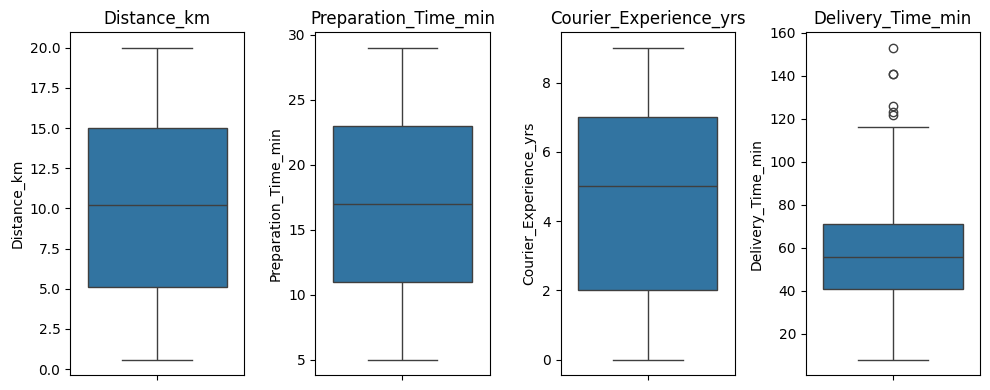

In [ ]:
plt.figure(figsize=(10, 4))

for i, col in enumerate(numeric_features):
    plt.subplot(1, len(numeric_features), i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

## Categorical features - Value counts

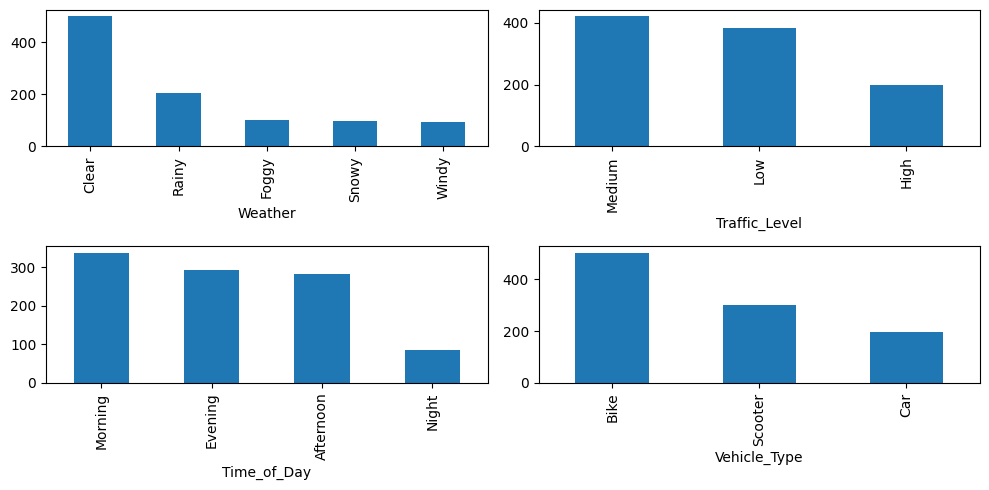

In [ ]:
plt.figure(figsize=(10, 5))

for i, col in enumerate(categorical_features):
    plt.subplot((len(categorical_features)+1)//2, 2, i + 1)
    # sns.boxplot(y=df[col])
    df[col].value_counts().plot(kind='bar')
    # plt.title(col)

plt.tight_layout()
plt.show()

## Features and labels

In [ ]:
X= df.drop('Delivery_Time_min', axis=1)
y= df['Delivery_Time_min']

## Heatmap to visualize correlations between features

<Axes: >

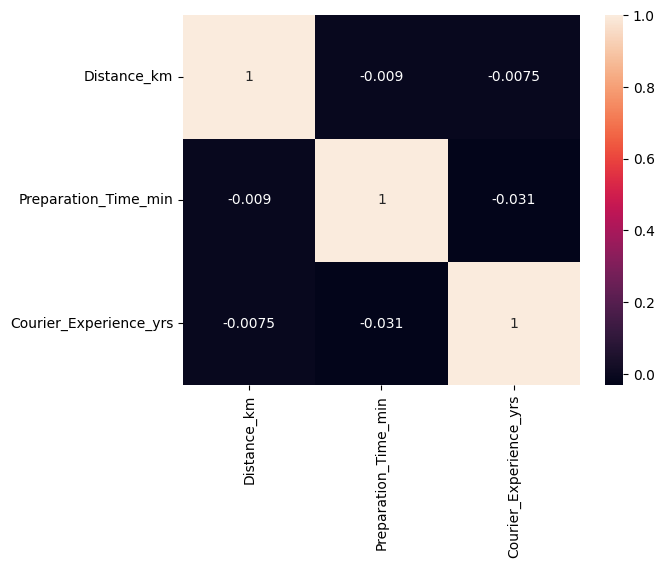

In [ ]:
numeric_columns = X.select_dtypes(exclude=['object']).columns
c= X[numeric_columns].corr()
sns.heatmap(c, annot=True)

In [ ]:
X = pd.get_dummies(
            X,
            columns=categorical_features,
            drop_first=True)
X

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12.0,1.0,False,False,False,True,True,False,False,False,False,False,True
1,16.42,20.0,2.0,False,False,False,False,False,True,True,False,False,False,False
2,9.52,28.0,1.0,True,False,False,False,True,False,False,False,True,False,True
3,7.44,5.0,1.0,False,True,False,False,False,True,False,False,False,False,True
4,19.03,16.0,5.0,False,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8.50,13.0,3.0,False,False,False,False,False,False,True,False,False,True,False
996,16.28,8.0,9.0,False,True,False,False,True,False,False,True,False,False,True
997,15.62,26.0,2.0,False,False,True,False,False,False,True,False,False,False,True
998,14.17,8.0,0.0,False,False,False,False,True,False,False,False,False,False,False


# Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (800, 14) Test shape: (200, 14)


# Model Training

In [ ]:
# Define a function for training and evaluating models
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluation Metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[name] = {'R2 score': r2,'MSE':mse,'RMSE': rmse,'MAE':mae}

    results = pd.DataFrame(results)
    return results

In [ ]:
# Define models
lr_model = LinearRegression()
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100,learning_rate=0.1,random_state=42)

models = {
    "XGBoost Regressor": xgb_model,
    "Random Forest Regressor": rfr_model,
    "Linear Regression": lr_model
}

# Call the function
results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

In [ ]:
results

,XGBoost Regressor,Random Forest Regressor,Linear Regression
R2 score,0.776914,0.762473,0.826189
MSE,99.992949,106.465966,77.906575
RMSE,9.999647,10.318235,8.826470
MAE,7.174253,7.142900,5.899169


**Linear Regression is the best model as it has the highest R2 Score and also low RMSE, MAE**

# Save the best model

In [ ]:
model_path = 'Linear_Regression_model.pkl'
model = lr_model

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

# Predict on New Data

In [ ]:
new_data = {
    'Distance_km': [10],
    'Preparation_Time_min': [12],
    'Courier_Experience_yrs': [1.0],
    'Weather_Foggy': [0],
    'Weather_Rainy': [0],
    'Weather_Snowy': [0],
    'Weather_Windy': [1],
    'Traffic_Level_Low': [1],
    'Traffic_Level_Medium': [0],
    'Time_of_Day_Evening': [0],
    'Time_of_Day_Morning': [0],
    'Time_of_Day_Night': [0],
    'Vehicle_Type_Car': [0],
    'Vehicle_Type_Scooter': [1]
}

new_df = pd.DataFrame(new_data)

# Prediction
lr_pred_new = lr_model.predict(new_df)

print("Estimated Delivery time(in minutes):", lr_pred_new[0])

Estimated Delivery time(in minutes): 47.719690906893874
